
[1. Выполните когортный анализ пользователей?](#51)

[2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.](#52)


In [8]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=2, style="whitegrid", rc={'figure.figsize' : (20,7)}
        )
df_customers  = pd.read_csv('https://drive.google.com/uc?id=1P7oRu4FiJM2Vp8pd0YnmDybb-k2NYZuM') 
df_orders     = pd.read_csv('https://drive.google.com/uc?id=1YImQmfaKE5hM-k1jhczuGhj4jycc5Rmh')
df_items      = pd.read_csv('https://drive.google.com/uc?id=1q_mVm-lkLQU1fj0CSCY-j8ru5lzauFNb')

In [9]:
df_customers.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [12]:
df_orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [13]:
df_items.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


<a id="51"></a>
# Выполните когортный анализ пользователей.

В качестве целевого действия будем рассматривать размещение заказа. Это означает желание пользователя совершить покупку, чем бы это желание в итоге не закончилось (полученнием товара или отменой заказа).

Когорты заказчиков будем формировать по месяцу первого размещения заказа.

Найдем месяц размещения первого заказа для каждого заказчика.

In [104]:
df_first_order_month = df_customers[['customer_id', 'customer_unique_id']]\
                                   .merge(df_orders, on = 'customer_id')\
                                   [['customer_unique_id', 'order_id', 'order_purchase_timestamp']]

df_first_order_month['order_purchase_timestamp'] = df_first_order_month.order_purchase_timestamp.astype('datetime64[M]')
df_first_order_month.columns = ['customer_unique_id','order_id','first_month']
df_first_order_month = df_first_order_month.groupby('customer_unique_id', as_index = False)\
                                           .agg({'first_month':'min'})
df_first_order_month

,customer_unique_id,first_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01
2,0000f46a3911fa3c0805444483337064,2017-03-01
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01
96092,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01
96093,ffff371b4d645b6ecea244b27531430a,2017-02-01
96094,ffff5962728ec6157033ef9805bacc48,2018-05-01


Агрегируем помесячно активность заказчиков по размещению заказов

In [105]:
df_orders_months = df_customers.merge(df_orders, on = 'customer_id', how = 'left')\
                               [['customer_unique_id', 'order_purchase_timestamp', 'order_id']]
df_orders_months.order_purchase_timestamp = df_orders_months.order_purchase_timestamp.astype('datetime64[M]')
df_orders_months = df_orders_months.groupby(['customer_unique_id','order_purchase_timestamp'], as_index = False)\
                                   .agg({'order_id':'count'})\
                                   .sort_values('order_id', ascending = False)
df_orders_months

,customer_unique_id,order_purchase_timestamp,order_id
7325,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,6
50622,83e7958a94bd7f74a9414d8782f87628,2017-01-01,4
76793,c8460e4251689ba205045f3ea17884a1,2018-08-01,4
67755,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,4
62196,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,4
...,...,...,...
32869,55a08a9545274dc36a0c5804389217d4,2017-03-01,1
32868,55a03f067a142cdde9f79f95a161b257,2018-01-01,1
32867,559df1e714566692202143c82bf531ca,2018-03-01,1
32866,559c99ed25c0bfe03e2e037c3205e9b6,2017-09-01,1


Проверим правильно ли получилось

In [106]:
df_orders_months.groupby(['customer_unique_id'], as_index = False)\
                                   .agg({'order_id':'count'})\
                                   .sort_values('order_id', ascending = False)

,customer_unique_id,order_id
52973,8d50f5eadf50201ccdcedfb9e2ac8455,10
76082,ca77025e7201e3b30c44b472ff346268,6
37797,6469f99c1f9dfae7733b25662e7f1782,6
90451,f0e310a6839dce9de1638e0fe5ab282a,6
37585,63cfc61cee11cbe306bff5857d00bfe4,5
...,...,...
32329,55e06703bd5d11ce8f8c2b7c5448425a,1
32328,55e01c1272a2c7981d2b756431bfd7aa,1
32327,55dfea89540867cbe96091b82db0cb06,1
32326,55df93f592e064d6c3f456160d848d00,1


In [107]:
df_orders_months.loc[df_orders_months.customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455']

,customer_unique_id,order_purchase_timestamp,order_id
54040,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-01,3
54033,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07-01,3
54036,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10-01,2
54038,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05-01,2
54039,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07-01,2
54037,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11-01,1
54035,8d50f5eadf50201ccdcedfb9e2ac8455,2017-09-01,1
54034,8d50f5eadf50201ccdcedfb9e2ac8455,2017-08-01,1
54032,8d50f5eadf50201ccdcedfb9e2ac8455,2017-06-01,1
54031,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-01,1


Все верно, в колонке order_id у нас теперь количество заказов пользователя по месяцам. Но количество как таковое нас не интересует, нам нужен только лишь сам факт активности. Если есть хотя бы один заказ, значит это вернувшийся пользователь. Переведем заказы в активность: 1 - признак активности данного заказчика в данном месяце

In [108]:
df_orders_months['order_id'] = 1
df_orders_months.columns= ['customer_unique_id','months','activity']
df_orders_months

,customer_unique_id,months,activity
7325,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,1
50622,83e7958a94bd7f74a9414d8782f87628,2017-01-01,1
76793,c8460e4251689ba205045f3ea17884a1,2018-08-01,1
67755,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,1
62196,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,1
...,...,...,...
32869,55a08a9545274dc36a0c5804389217d4,2017-03-01,1
32868,55a03f067a142cdde9f79f95a161b257,2018-01-01,1
32867,559df1e714566692202143c82bf531ca,2018-03-01,1
32866,559c99ed25c0bfe03e2e037c3205e9b6,2017-09-01,1


Теперь нужно создать сетку из когорт по вертикали и контрольных месяцев по горизонтали, а потом заполнить ее данными по активности заказчиковю
Создадим датафрейм с контрольными месяцами 

In [109]:
min = df_first_order_month.first_month.min()
max = df_first_order_month.first_month.max()
df_months = pd.DataFrame(pd.date_range(min, max, freq = 'MS'))
df_months.columns = ['months']
df_months

,months
0,2016-09-01
1,2016-10-01
2,2016-11-01
3,2016-12-01
4,2017-01-01
5,2017-02-01
6,2017-03-01
7,2017-04-01
8,2017-05-01
9,2017-06-01


Сделаем кросс-джойн датасетов заказчиков с их первыми месяцами и контрольных месяцев.
Таким образом каждому заказчику с первым месяцем добавятся строки во всеми контрольными месяцами

In [110]:
df_first_order_month['key'] = 1
df_months['key'] = 1
t = df_first_order_month.merge(df_months, on = 'key')[['customer_unique_id','first_month','months']]
t

,customer_unique_id,first_month,months
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2016-09-01
1,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2016-10-01
2,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2016-11-01
3,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2016-12-01
4,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-01-01
...,...,...,...
2498491,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-06-01
2498492,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-07-01
2498493,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-08-01
2498494,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-09-01


Теперь для каждого заказчика отбросим строки с контрольными месяцами раньше месяца первой покупки - поскольку до первой покупки заказчик точно ничего не покупал и там точно пусто

In [111]:
t = t.loc[t.months >= t.first_month]
t.sort_values('months')

,customer_unique_id,first_month,months
708370,4854e9b3feff728c13ee5fc7d1547e92,2016-09-01,2016-09-01
6188,009b0127b727ab0ba422f6d9604487c7,2016-09-01,2016-09-01
1282112,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-01,2016-09-01
1796522,b7d76e111c89f7ebf14761390f0f7d17,2016-09-01,2016-09-01
775659,4f3865fa2a981933ea86fc691d97f643,2016-10-01,2016-10-01
...,...,...,...
421563,2b1b00a75b3add7b127e797557a384dd,2018-01-01,2018-10-01
1927119,c53e944da3d3ad66ccb7527165b78681,2018-03-01,2018-10-01
421589,2b1bccb3468960cd5c9e613bb3b79d7b,2018-04-01,2018-10-01
421615,2b1be7436a5b60f540df8b37e306b178,2018-02-01,2018-10-01


Впишем предварительно собранную в df_orders_months активность заказчиков в контрольных месяцам в соответствующие строки нашей сетки

In [112]:
df_table=t.merge(df_orders_months, on = ['customer_unique_id','months'], how = 'left').fillna(0)
df_table

,customer_unique_id,first_month,months,activity
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-05-01,1.0
1,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-06-01,0.0
2,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-07-01,0.0
3,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-08-01,0.0
4,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-09-01,0.0
...,...,...,...,...
1009791,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-06-01,0.0
1009792,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-07-01,0.0
1009793,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-08-01,0.0
1009794,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-09-01,0.0


Наконец, выведем таблицу retention

In [113]:
pd.set_option('display.max_columns', None) 
df_table.pivot_table(index = 'first_month', columns = 'months', values = 'activity', aggfunc = 'mean')

months,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01
first_month,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10-01,NaN,1.0,0.0,0.0,0.0,0.000000,0.000000,0.003115,0.000000,0.000000,0.003115,0.000000,0.003115,0.000000,0.003115,0.000000,0.003115,0.000000,0.003115,0.000000,0.006231,0.006231,0.000000,0.000000,0.000000,0.000000
2016-12-01,NaN,NaN,NaN,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-01,NaN,NaN,NaN,NaN,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,0.000000,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.000000,0.001309,0.000000,0.000000
2017-02-01,NaN,NaN,NaN,NaN,NaN,1.000000,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,0.000000,0.000000,0.000000
2017-03-01,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517,0.000000,0.000000
2017-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,0.000000,0.000000
2017-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,0.000000,0.000000
2017-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,0.000000,0.000000


<a id="52"></a>
# В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.

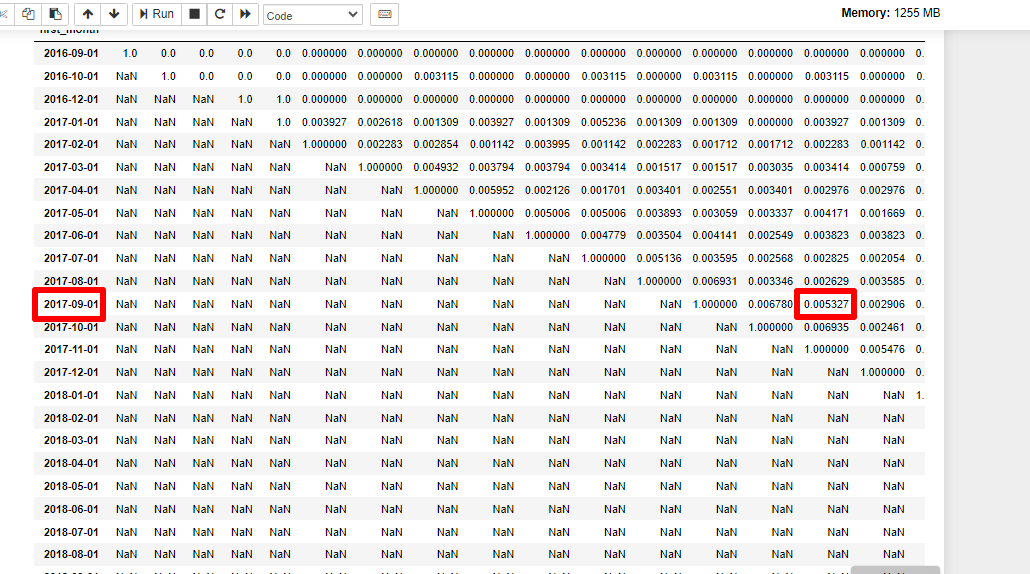